# Greedy layer-wise AE and VAE for tomographies

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io
import numpy as np
import glob
from PIL import Image

In [2]:
# get files list
files = (glob.glob('Coll*/data/*/*/*/Pr*/*rec.tif'))

In [3]:
# get all image arrays
Xs = []
for file in files:
    im = io.imread(file)
    Xs.append(im)

In [4]:
# size of image to work with
size = 60

# get the total number of images available
total_images = 0
for i in Xs:
    total_images+=len(i)

# data array
X = np.zeros(shape=(total_images,size,size))
idx = 0

# go over all images, scale them and pad with black space if needed 
for i in range(len(Xs)):
    for j in range(150,len(Xs[i])-150):
        img = Image.fromarray(Xs[i][j])
        img.thumbnail((size,size),Image.ANTIALIAS)
        img = np.asarray(img)
        pad = 0
        ax = 0
        if (img.shape[0]<size):
            pad = size-img.shape[0]
            pad = (np.zeros((pad//2,img.shape[1])), np.zeros((pad-pad//2,img.shape[1])))
            img = np.concatenate((pad[0],img,pad[1]),axis=0)
        elif (img.shape[1]<size):
            pad = size-img.shape[1]
            pad = (np.zeros((img.shape[0],pad//2)), np.zeros((img.shape[0],pad-pad//2)))
            img = np.concatenate((pad[0],img,pad[1]),axis=1)
        X[idx] = img
        idx+=1
X.shape     

(7871, 60, 60)

In [5]:
# normalize data
X2 = (X-X.min())/(X.max()-X.min())

In [6]:
# normalize data, after some trial and error, I arrived to this process
# also clean vertical lines - they are just artifacts from the imaging process
X_train = []
for idx in range(len(X2)):
    x = X2[idx]
    move = x.mean()-0.5*x.std()
    x = np.maximum(x-move,0)
    x = np.minimum(x*3,1)
    cols = x.mean(axis=0)
    mean = x.mean()
    if (mean>0.08):
        for i in range(len(cols)):
            if cols[i]>0.4:
                x[:,i] = 0
        X_train.append(x)
X_train = np.array(X_train)

0.6577359633562174 0.0


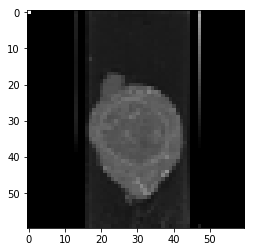

In [11]:
fig,ax = plt.subplots(ncols=1,figsize=(12,4))

# check some images at random
idx = np.random.randint(len(X_train))
x = X_train[idx]
print(x.max(),x.min())
x[0,0]=1
x[0,1]=0

ax.imshow(x,cmap='gray')
plt.show()

In [56]:
from keras.models import Model
from keras.layers import Input, Dense, Convolution2D, Convolution2DTranspose 
from keras.layers import MaxPooling2D, Flatten, Dropout, Reshape, Add

In [14]:
# flatten data
X_flat = np.zeros((len(X_train),3600))

for i in range(len(X_train)):
    X_flat[i] = X_train[i].flatten()

flat = np.prod(X_train[0].shape)

In [59]:
input_layer = Input(shape=[flat])
hidden = Dense(1024,activation='relu')(input_layer)
z_input = Input(shape=[1024])
output = Dense(flat,activation='sigmoid')(Add()([hidden,z_input]))

model = Model(inputs=[input_layer,z_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

encoder = Model(inputs=input_layer,outputs=hidden)
decoder = Model(inputs=[z_input,input_layer], outputs=output)

In [60]:
model.fit([X_flat,np.zeros((len(X_flat),1024))],X_flat,batch_size=10,epochs=10)

Epoch 1/10
2771/2771 [==============================] - 37s 13ms/step - loss: 0.3088 - acc: 0.4200
Epoch 2/10
2771/2771 [==============================] - 36s 13ms/step - loss: 0.2870 - acc: 0.4217
Epoch 3/10
2771/2771 [==============================] - 36s 13ms/step - loss: 0.2835 - acc: 0.4218
Epoch 4/10
2771/2771 [==============================] - 35s 12ms/step - loss: 0.2820 - acc: 0.4218
Epoch 5/10
2771/2771 [==============================] - 36s 13ms/step - loss: 0.2811 - acc: 0.4218
Epoch 6/10
2771/2771 [==============================] - 35s 13ms/step - loss: 0.2805 - acc: 0.4218
Epoch 7/10
2771/2771 [==============================] - 35s 13ms/step - loss: 0.2800 - acc: 0.4218
Epoch 8/10
2771/2771 [==============================] - 35s 13ms/step - loss: 0.2797 - acc: 0.4219
Epoch 9/10
2771/2771 [==============================] - 36s 13ms/step - loss: 0.2794 - acc: 0.4219
Epoch 10/10
2771/2771 [==============================] - 35s 13ms/step - loss: 0.2792 - acc: 0.4219


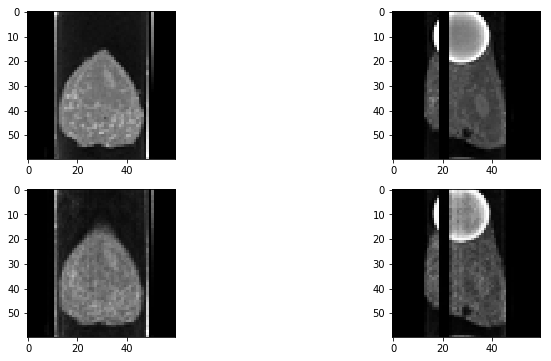

In [65]:
# reconstruct images - AE only
idx = np.random.randint(len(X_flat),size=2)
pred = model.predict([X_flat[idx],np.zeros((len(idx),1024))])

fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(12,6))

ax[0,0].imshow(X_flat[idx[0]].reshape(size,size),cmap='gray')
ax[0,1].imshow(X_flat[idx[1]].reshape(size,size),cmap='gray')

ax[1,0].imshow(pred[0].reshape(size,size),cmap='gray')
ax[1,1].imshow(pred[1].reshape(size,size),cmap='gray')

plt.show()

In [66]:
Z = encoder.predict(X_flat)
Z_norm = (Z-Z.min())/(Z.max()-Z.min())

In [129]:
from vae2 import VariationalAutoencoder as VVV

In [144]:
vae = VVV(1024,[256,32])

In [ ]:
vae.fit(Z_norm,epochs=50,batch=5)

Epoch: 1
Cost: -157378.33331298828
Epoch: 2
Cost: -156723.71084594727
Epoch: 3
Cost: -156322.84393310547
Epoch: 4
Cost: -156135.41235351562
Epoch: 5
Cost: -155698.78593444824
Epoch: 6
Cost: -155393.60525512695
Epoch: 7
Cost: -155268.29136657715
Epoch: 8
Cost: -154791.6336364746
Epoch: 9
Cost: -154821.84562683105
Epoch: 10
Cost: -154640.6022491455
Epoch: 11
Cost: -154344.85041809082
Epoch: 12
Cost: -154208.2922515869
Epoch: 13
Cost: -154087.57530212402
Epoch: 14
Cost: -153890.02996826172
Epoch: 15
Cost: -154051.7749786377
Epoch: 16
Cost: -153860.7470703125
Epoch: 17


In [146]:
pred = vae.predict(Z_norm)
(pred==Z_norm).mean(),(pred-Z_norm).mean(),pred.mean()

(0.4734269978121617, 0.0010611168, 0.013953304)

In [147]:
Z_prime = pred * (Z.max()-Z.min()) + Z.min()
reconstructed = decoder.predict([Z_prime,np.zeros(shape=(len(pred),3600))])

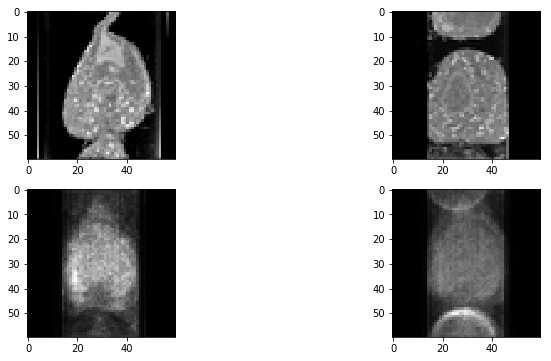

In [148]:
# reconstruct images through the AE and VAE
idx = np.random.randint(len(X_flat),size=2)

fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(12,6))

ax[0,0].imshow(X_flat[idx[0]].reshape(size,size),cmap='gray')
ax[0,1].imshow(X_flat[idx[1]].reshape(size,size),cmap='gray')

ax[1,0].imshow(reconstructed[idx[0]].reshape(size,size),cmap='gray')
ax[1,1].imshow(reconstructed[idx[1]].reshape(size,size),cmap='gray')

plt.show()

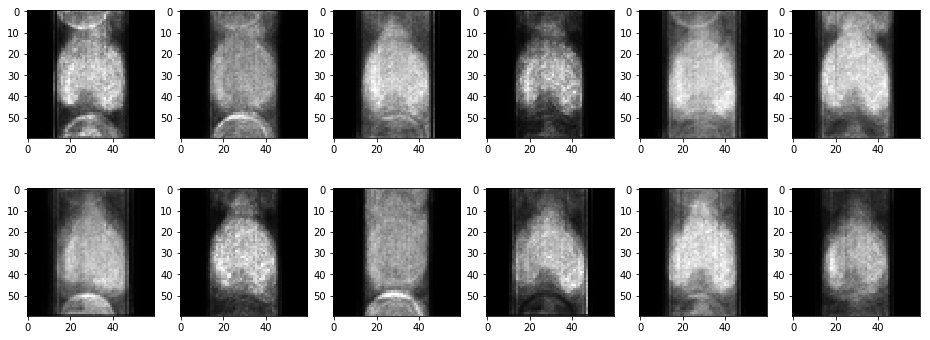

In [154]:
# generate novel images
n = 6
genN = vae.generate(n*2)

gen_prime = genN * (Z.max()-Z.min()) + Z.min()
reconstructed = decoder.predict([gen_prime,np.zeros(shape=(len(gen_prime),3600))])


fig,ax = plt.subplots(ncols=n,nrows=2,figsize=(16,6))

for i in range(n):
    ax[0,i].imshow((reconstructed[i].reshape(size,size)),cmap='gray')
    ax[1,i].imshow((reconstructed[i+n].reshape(size,size)),cmap='gray')   
plt.show()